In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


In [61]:
#read excel file with columns to be used
df = pd.read_excel('Solaranlage_2020.xlsx', 
                    skiprows=3, usecols=['### UNIX-Zeitstempel',' Entladung(Wh)', ' Ladung(Wh)',
       ' Erzeugung(Wh)', ' Verbrauch(Wh)', ' Netz-Einspeisung(Wh)',
       ' Netz-Bezug(Wh)'], index_col='### UNIX-Zeitstempel')  
#rename columns without leading whitespace
original_columns = list(df.columns)
new_cols = []
for col in original_columns:
    new_cols.append(col.strip())
#create dict to rename cols
col_dict = dict(zip(original_columns, new_cols))
#set index as datetime 
df.index = pd.to_datetime(df.index, unit='s', utc=True).map(lambda x: x.tz_convert('Europe/Berlin'))
df.index.rename('Datum',inplace=True)
df.rename(columns=col_dict, inplace=True)
df.sort_index(inplace=True)  
#calculate kwh from Wh
kwh_df = df / 1000    
#rename columns to Kwh
for col in kwh_df.columns:
    kwh_df.rename(columns={col: col.replace('(Wh)','(Kwh)')}, inplace=True)
kwh_df.head()


,Entladung(Kwh),Ladung(Kwh),Erzeugung(Kwh),Verbrauch(Kwh),Netz-Einspeisung(Kwh),Netz-Bezug(Kwh)
Datum,,,,,,
2020-10-27 14:25:00+01:00,0.0,0.0,0.0,0.03038,0.0,0.03038
2020-10-27 14:30:00+01:00,0.0,0.0,0.0,0.03043,0.0,0.03043
2020-10-27 14:35:00+01:00,0.0,0.0,0.0,0.02784,0.0,0.02784
2020-10-27 14:40:00+01:00,0.0,0.0,0.0,0.02902,0.0,0.02902
2020-10-27 14:45:00+01:00,0.0,0.0,0.0,0.02839,0.0,0.02839


In [62]:
#umrechnung von Kwh in Kw
kwh_df['Erzeugung(kW)'] = kwh_df['Erzeugung(Kwh)'] / (5/60)


In [63]:
#wie viel wird erzeugt?
kwh_df['cumsum_erzeugung']=kwh_df['Erzeugung(kW)'].rolling(window=1).sum()


In [69]:
#pick a random single day from df
day = kwh_df['2020-11-06':'2020-11-06']
day['2020-11-06 06:00:00':'2020-11-06 11:00:00'].head(30)


,Entladung(Kwh),Ladung(Kwh),Erzeugung(Kwh),Verbrauch(Kwh),Netz-Einspeisung(Kwh),Netz-Bezug(Kwh),Erzeugung(kW),cumsum_erzeugung
Datum,,,,,,,,
2020-11-06 06:00:00+01:00,0.0,0.00015,0.00000,0.01387,0.00000,0.01402,0.00000,0.00000
2020-11-06 06:05:00+01:00,0.0,0.00015,0.00000,0.01780,0.00000,0.01795,0.00000,0.00000
2020-11-06 06:10:00+01:00,0.0,0.00015,0.00000,0.03287,0.00000,0.03302,0.00000,0.00000
2020-11-06 06:15:00+01:00,0.0,0.00015,0.00000,0.02299,0.00000,0.02314,0.00000,0.00000
2020-11-06 06:20:00+01:00,0.0,0.00015,0.00000,0.01669,0.00000,0.01684,0.00000,0.00000
2020-11-06 06:25:00+01:00,0.0,0.00017,0.00199,0.01750,0.00000,0.01568,0.02388,0.02388
2020-11-06 06:30:00+01:00,0.0,0.00023,0.00432,0.02544,0.00000,0.02135,0.05184,0.05184
2020-11-06 06:35:00+01:00,0.0,0.00021,0.00858,0.01413,0.00000,0.00576,0.10296,0.10296
2020-11-06 06:40:00+01:00,0.0,0.00123,0.01467,0.01356,0.00098,0.00110,0.17604,0.17604


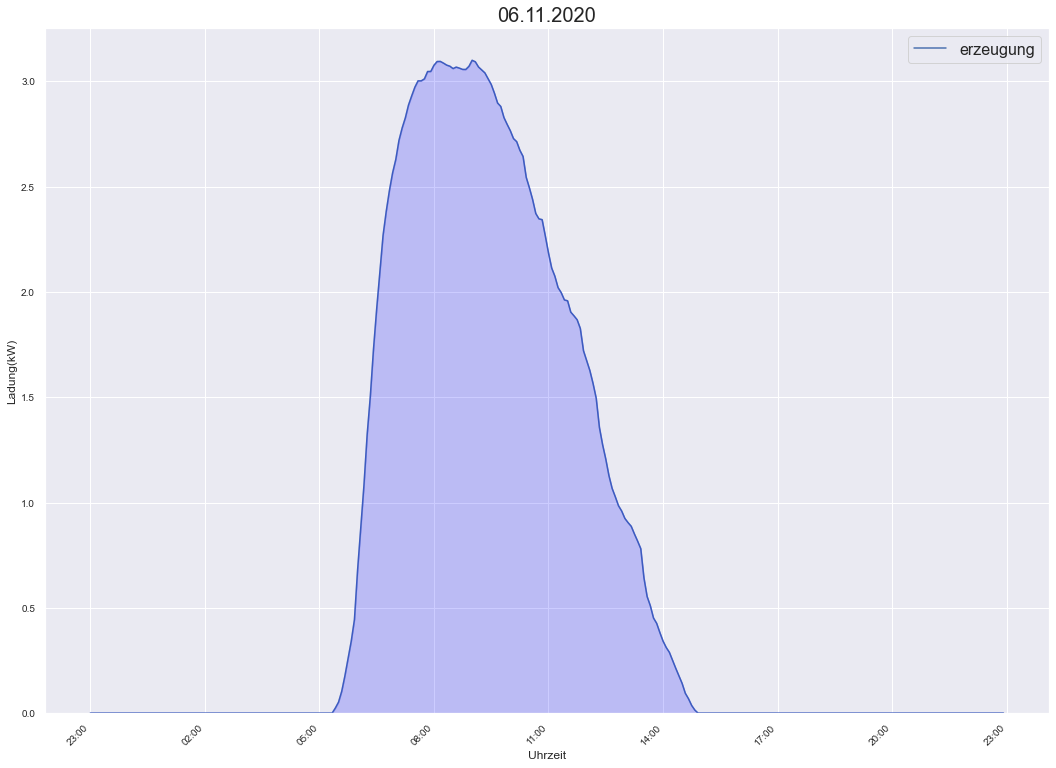

In [65]:
custom_params = {
                 'figure.figsize':(18,14),
                 "font.size":20,
                 "axes.titlesize":20,
                 "axes.labelsize":12,
                 "legend.fontsize":16,
                 "xtick.labelsize":10,
                 "ytick.labelsize":10}
sns.set_theme(style="darkgrid", rc=custom_params)
# Define the date format
date_form = DateFormatter("%H:%M")


fig, ax = plt.subplots()
#g0 = sns.lineplot(x="Datum", y=5, data=day, ax=ax, label='Maximale Ladung')
g1 = sns.lineplot(x='Datum', y='cumsum_erzeugung', data=day, ax=ax, label='erzeugung')

#plot area under curve
day['cumsum_erzeugung'].plot.area(stacked=False, alpha=0.2, ax=ax, legend=False, color='blue')

plt.title(day.index[0].strftime('%d.%m.%Y'))
ax.xaxis.set_major_formatter(date_form)
ax.set_xlabel('Uhrzeit')
plt.ylabel('Ladung(kW)')
plt.xticks(rotation=45)
plt.show()

In [65]:
df.head()

,Entladung(Wh),Ladung(Wh),Erzeugung(Wh),Verbrauch(Wh),Netz-Einspeisung(Wh),Netz-Bezug(Wh)
Datum,,,,,,
2020-10-27 14:25:00,0.0,0.0,0.0,30.38,0.0,30.38
2020-10-27 14:30:00,0.0,0.0,0.0,30.43,0.0,30.43
2020-10-27 14:35:00,0.0,0.0,0.0,27.84,0.0,27.84
2020-10-27 14:40:00,0.0,0.0,0.0,29.02,0.0,29.02
2020-10-27 14:45:00,0.0,0.0,0.0,28.39,0.0,28.39
